In [1]:
number_of_days = 2

In [2]:
import sys
print(sys.executable)

c:\Users\anton\AppData\Local\Programs\Python\Python313\python.exe


In [3]:
!pip list

Package                   Version
------------------------- --------------
anyio                     4.8.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     25.1.0
babel                     2.17.0
beautifulsoup4            4.13.3
bleach                    6.2.0
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.13
decorator                 5.2.1
defusedxml                0.7.1
executing                 2.2.0
fastjsonschema            2.21.1
filelock                  3.17.0
fonttools                 4.56.0
fqdn                      1.5.1
frozendict                2.4.6
fsspec                    2025.2.0
h11                       0.14.0
html5lib  

In [4]:
import numpy as np  # Importing numpy for numerical operations
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
from ipywidgets import widgets
from IPython.display import display
from Gen_SPY_With_Indicators import simulate_stock  # Importing simulation function
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import matplotlib.ticker as mticker  # For proper Y-axis formatting

def generate_signals(df, stop_loss_pct=0.02):
    """ Generates trade signals based on ORB, VWAP, 8EMA, PM High/Low, and Yest High/Low """

    df['Signal'] = ''
    df['Stop_Loss'] = np.nan  # Initialize Stop_Loss column

    # Buy Call: Price breaks ORB High & supported by 8EMA & VWAP
    df.loc[
        (df['Close'] > df['ORB_High']) & 
        (df['Close'] > df['VWAP']) & 
        (df['Close'] > df['8EMA']),
        'Signal'
    ] = 'BUY CALL'

    # Sell Put: Price breaks ORB Low & rejected by 8EMA & VWAP
    df.loc[
        (df['Close'] < df['ORB_Low']) & 
        (df['Close'] < df['VWAP']) & 
        (df['Close'] < df['8EMA']),
        'Signal'
    ] = 'BUY PUT'

    # Boost Call Confidence if PM High or Yesterday's High is broken
    df.loc[
        (df['Signal'] == 'BUY CALL') & 
        ((df['Close'] > df['PM_High']) | (df['Close'] > df['Yest_High'])),
        'Signal'
    ] = 'STRONG BUY CALL'

    # Boost Put Confidence if PM Low or Yesterday's Low is broken
    df.loc[
        (df['Signal'] == 'BUY PUT') & 
        ((df['Close'] < df['PM_Low']) | (df['Close'] < df['Yest_Low'])),
        'Signal'
    ] = 'STRONG BUY PUT'

    # Add stop loss levels
    df.loc[df['Signal'].isin(['BUY CALL', 'STRONG BUY CALL']), 'Stop_Loss'] = df['Close'] * (1 - stop_loss_pct)
    df.loc[df['Signal'].isin(['BUY PUT', 'STRONG BUY PUT']), 'Stop_Loss'] = df['Close'] * (1 + stop_loss_pct)

    return df

# Simulate Stock Data for 2 Days
simulated_data, yesterday_high, yesterday_low = simulate_stock(number_of_days)

# Apply Signal Generation
simulated_data = generate_signals(simulated_data)

import plotly.express as px
import plotly.graph_objects as go

# Set seaborn style
sns.set(style="whitegrid")

# Create a subplot
fig = make_subplots(rows=1, cols=1)

# Function to update the plot based on the toggle button
def update_plot(change):
    fig.data = []  # Clear existing traces

    if toggle_button.value:
        # Add candlestick traces for each day
        for day in simulated_data["Day"].unique():
            day_data = simulated_data[simulated_data["Day"] == day]
            pm_data = day_data[day_data["Session"] == "PM"]
            market_data = day_data[day_data["Session"] == "Regular Market"]

            if not pm_data.empty:
                fig.add_trace(go.Candlestick(x=pm_data['Timestamp'], open=pm_data['Open'], high=pm_data['High'], low=pm_data['Low'], close=pm_data['Close'], name=f"PM Day {day}"))
            if not market_data.empty:
                fig.add_trace(go.Candlestick(x=market_data['Timestamp'], open=market_data['Open'], high=market_data['High'], low=market_data['Low'], close=market_data['Close'], name=f"Regular Market Day {day}"))
    else:
        # Add line traces for each day
        for day in simulated_data["Day"].unique():
            day_data = simulated_data[simulated_data["Day"] == day]
            pm_data = day_data[day_data["Session"] == "PM"]
            market_data = day_data[day_data["Session"] == "Regular Market"]

            fig.add_trace(go.Scatter(x=pm_data['Timestamp'], y=pm_data['Close'], mode='lines', name=f"PM Day {day}", line=dict(color="black", dash="dot"), opacity=0.7))
            fig.add_trace(go.Scatter(x=market_data['Timestamp'], y=market_data['Close'], mode='lines', name=f"Regular Market Day {day}", line=dict(color="steelblue"), opacity=0.8))

    # Add traces for indicators
    fig.add_trace(go.Scatter(x=simulated_data['Timestamp'], y=simulated_data['8EMA'], mode='lines', name="8EMA", line=dict(color="orange")))
    fig.add_trace(go.Scatter(x=simulated_data['Timestamp'], y=simulated_data['VWAP'], mode='lines', name="VWAP", line=dict(color="blue")))

    # Add traces for ORB and PM High/Low
    for day in simulated_data['Day'].unique():
        day_data = simulated_data[simulated_data['Day'] == day]
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['ORB_High'], mode='lines', name="ORB High" if day == 1 else "", line=dict(color="green", dash="dash")))
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['ORB_Low'], mode='lines', name="ORB Low" if day == 1 else "", line=dict(color="red", dash="dash")))
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['PM_High'], mode='lines', name="PM High" if day == 1 else "", line=dict(color="green", dash="dot")))
        fig.add_trace(go.Scatter(x=day_data['Timestamp'], y=day_data['PM_Low'], mode='lines', name="PM Low" if day == 1 else "", line=dict(color="red", dash="dot")))

        market_open_time = day_data['Timestamp'].iloc[0]
        market_close_time = day_data['Timestamp'].iloc[-1]
        if day == 1:
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[yesterday_high, yesterday_high], mode='lines', name="Yesterday's High", line=dict(color="gray", dash="dashdot"), opacity=0.7))
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[yesterday_low, yesterday_low], mode='lines', name="Yesterday's Low", line=dict(color="brown", dash="dashdot"), opacity=0.7))
        else:
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[day_data['Yest_High'].iloc[0], day_data['Yest_High'].iloc[0]], mode='lines', name="Yesterday's High" if day == 2 else "", line=dict(color="gray", dash="dashdot"), opacity=0.7))
            fig.add_trace(go.Scatter(x=[market_open_time, market_close_time], y=[day_data['Yest_Low'].iloc[0], day_data['Yest_Low'].iloc[0]], mode='lines', name="Yesterday's Low" if day == 2 else "", line=dict(color="brown", dash="dashdot"), opacity=0.7))

    # Update layout for better appearance
    fig.update_layout(
        title="Simulated Stock Price with PM, 8EMA, VWAP, ORB, & Yesterday's High/Low",
        xaxis_title="Time",
        yaxis_title="Stock Price",
        legend_title="Legend",
        xaxis=dict(tickangle=45),
        template="seaborn"
    )

    # Show the plot
    fig.show()

# Create a toggle button
toggle_button = widgets.ToggleButton(
    value=False,
    description='Toggle Candlestick',
    disabled=False,
    button_style='',
    tooltip='Toggle between line and candlestick chart',
    icon='line-chart'
)

# Attach the update function to the toggle button
toggle_button.observe(update_plot, names='value')

# Display the toggle button
# display(toggle_button)

# Initial plot update
update_plot(None)

# Print any part of the simulated data that contains BUY CALL or BUY PUT signals during Regular Market session
print(simulated_data[(simulated_data['Signal'].isin(['BUY CALL', 'BUY PUT', 'STRONG BUY CALL', 'STRONG BUY PUT'])) & 
                     (simulated_data['Session'] == 'Regular Market')])

c:\Users\anton\OneDrive\Documents\GitHub\Financial-Engineering-Project\Gen_SPY_With_Indicators.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_df[['ORB_High', 'ORB_Low']] = day_df[['ORB_High', 'ORB_Low']].fillna(method='ffill')
c:\Users\anton\OneDrive\Documents\GitHub\Financial-Engineering-Project\Gen_SPY_With_Indicators.py:115: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_df[['PM_High', 'PM_Low']] = day_df[['PM_High', 'PM_Low']].fillna(method='ffill')
c:\Users\anton\OneDrive\Documents\GitHub\Financial-Engineering-Project\Gen_SPY_With_Indicators.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  day_df[['ORB_High', 'ORB_Low']] = day_df[['ORB_High', 'ORB_Low']].fillna(method='ffill')
c:\Users\anton

               Timestamp       Close  Volume         Session  Day        8EMA  \
350  2023-02-20 09:50:00  609.997102   17368  Regular Market    1  610.065459   
351  2023-02-20 09:51:00  609.996113    5631  Regular Market    1  610.050049   
352  2023-02-20 09:52:00  609.988953   15913  Regular Market    1  610.036472   
353  2023-02-20 09:53:00  609.967846    5854  Regular Market    1  610.021222   
354  2023-02-20 09:54:00  609.927569    9089  Regular Market    1  610.000410   
...                  ...         ...     ...             ...  ...         ...   
1431 2023-02-21 15:51:00  608.819526    9625  Regular Market    2  608.842589   
1432 2023-02-21 15:52:00  608.825862   11519  Regular Market    2  608.838872   
1433 2023-02-21 15:53:00  608.820355    7217  Regular Market    2  608.834757   
1434 2023-02-21 15:54:00  608.825369    5177  Regular Market    2  608.832671   
1437 2023-02-21 15:57:00  608.816823   12500  Regular Market    2  608.829920   

            VWAP    ORB_Hig

                           Open       Close        High         Low  Volume  \
Timestamp                                                                     
2023-02-20 04:00:00  610.003991  609.807323  610.003991  609.774078   80800   
2023-02-20 04:30:00  609.799008  609.983483  610.207127  609.799008   81417   
2023-02-20 05:00:00  610.029657  610.055752  610.244980  610.029657   72750   
2023-02-20 05:30:00  610.030294  610.039063  610.178354  609.940398   75378   
2023-02-20 06:00:00  609.912585  610.052217  610.075368  609.813293   78560   

                     Day  
Timestamp                 
2023-02-20 04:00:00    6  
2023-02-20 04:30:00    6  
2023-02-20 05:00:00    6  
2023-02-20 05:30:00    6  
2023-02-20 06:00:00    6  


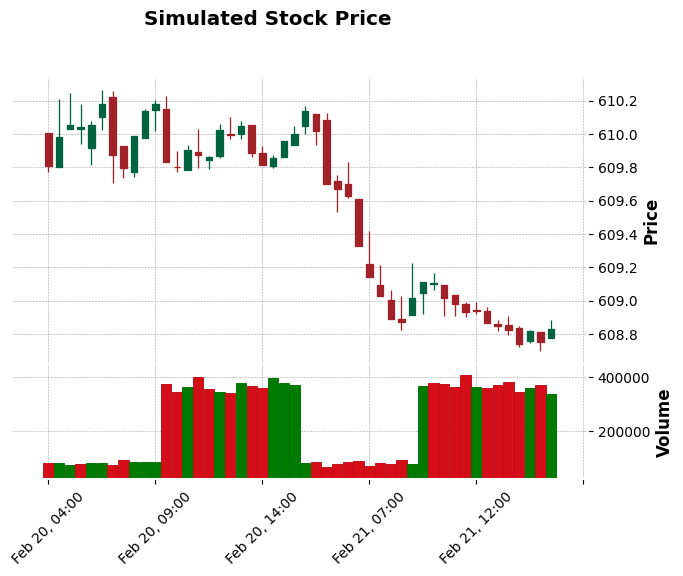

In [5]:
from generate_candlestick_df import generate_candlestick
import mplfinance as fplt

# Generate candlestick data
candlestick_data = generate_candlestick(simulated_data)

# Prepare the data for mplfinance
candlestick_data.set_index('Timestamp', inplace=True)

print(candlestick_data.head())

# Select the columns required for candlestick plot
candlestick_data = candlestick_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Plot the data as a candlestick chart
fplt.plot(
    candlestick_data,
    type='candle',
    style='charles',
    title="Simulated Stock Price",
    ylabel='Price',
    volume=True
)
